## Example: Computing The Price of Zero Coupon United States Treasury Bills
Zero coupon United States Treasury Bills, sometimes called `T-bills` or just `Zeros`, are marketable fixed-income debt securities that pay an investor a defined amount, called the face or par value, at the bill’s termination. 

### Pricing
The price of a zero-coupon Treasury bill $V_{B}$ with an effective interest rate of $\bar{r}$ and maturity of `T`-years at auction is the discounted face (par) value $V_{P}$ such that the net present value (NPV) of the bill is zero:

$$
\begin{equation}    
\text{NPV}(T,r) = -V_{B} + \mathcal{D}_{T,0}^{-1}(\bar{r})\cdot{V_{P}} = 0
\end{equation}
$$

or equivalently:

$$
\begin{equation}
    V_{B}(T, \bar{r}) = \mathcal{D}_{T,0}^{-1}(\bar{r})\cdot{V_{P}}
\end{equation}
$$
    
The quantity `T` denotes the duration of the bill (in years),  $\bar{r}$ is the effective annualized interest rate, and $\mathcal{D}_{T,0}^{-1}(\bar{r})$ is the inverse of the multistep discount factor. For T-bills, the interest is typically compounded twice a year. Thus, a typical discrete discount factor takes the form:

$$
\mathcal{D}_{T,0}(\bar{r}) = \left(1+\frac{\bar{r}}{2}\right)^{2T}
$$

where $T$ is the bill’s duration, measured in units of `years` (assuming a `365-day` year), and $\bar{r}$ denotes the interest rate (designated as the `investment rate` in auction datasets, or the `yield` in `secondary market quotes`).

### Learning objectives
This example will familiarize students with computing the price of United States `T-bills`. 

* Objective 1: First, we'll compute the price of `T-bills`, and validate our simulated prices using Treasury auction data from `2022` and `2023`. 
* Objective 2: Then, we'll show the price of treasury bills is inversely proportional to interest rate of the `T-bill`.

### Setup
We load the [VLQuantitativeFinancePackage.jl](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl) package, and several other external [Julia](https://julialang.org/downloads/https://julialang.org/downloads/) packages, as well as some helper code, by calling the [include(...)](https://docs.julialang.org/en/v1/manual/code-loading/https://docs.julialang.org/en/v1/manual/code-loading/) command on the file `Include.jl`:

In [1]:
include("Include.jl");

#### Constants

In [2]:
number_of_samples = 7;
β₁ = 0.8;
β₂ = 1.2;
β = range(β₁, stop = β₂, length = number_of_samples) |> collect;

#### Data
We'll explore `T-bill` prices from United States Treasury auctions between May and August 2023 downloaded using the [Auction query functionality of TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/). We load the `CSV` dataset using the `MyTreasuryBillDataSet()` function, which returns the auction data as a `DataFrame`:

In [3]:
dataset = MyTreasuryBillDataSet();

## Objective 1: Computing the Price of Treasury Bills at Auction
We begin the task of computing the T-bill price by building a discounting model. In this case, let's construct an instance of the `DiscreteCompoundingModel()` type and store this discount model in the `discount_model` variable:

In [4]:
discount_model = DiscreteCompoundingModel();

Next, let's build a zero-coupon Treasury bill model, which is an instance of the `MyUSTreasuryZeroCouponBondModel` type using the `build(...)` method. The `build(...)` methods requires two arguments: the `par` value of the `T-bill`, and the `n` argument, number of compounding periods per year. Store the zero-coupon model in the `model` variable:

In [5]:
model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100.0, n = 2
));

Finally, we compute the price of zero-coupon `T-bills` and compare the computed versus price versus the price observed at auction. We process each entry in the `dataset` using a `for-loop`. During each iteration of the loop:

* We get data from the `dataset` DataFrame and update the `T-bill` model instance. In particular, we set the observed price to the variable `VB`, we set the duration `T` field (which we convert to the number of years using the `securityterm` function) and the investment rate field, i.e., the annual interest rate on the `model` instance
* Next, we compute the price of the `T-bill` using the [Julia piping operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) `|>` in compbination with the discounting model using short-cut syntax
* We then calculate the percentage error between the estimated and observed `T-bill` price, and store the simulation data for each iteration in the `computed_price_table` DataFrame using the `push!(...)` function

In [6]:
number_of_bills = nrow(dataset)
computed_price_table = DataFrame();
for i ∈ 1:number_of_bills
    
    VB = dataset[i, :Price];
    model.T = dataset[i, Symbol("Security Term")] |> String |> securityterm;
    model.rate = dataset[i, Symbol("Investment Rate")];
        
    price_computed = model |> discount_model |> x-> x.price;
    error = 100*abs((VB - price_computed)/(price_computed));
    
    results_tuple = (
        CUSIP = dataset[i, :CUSIP],
        term = dataset[i, Symbol("Security Term")],
        rate = (dataset[i, Symbol("Investment Rate")] |> x-> 100*x),
        computed =  price_computed,
        actual = VB,
        error = error
    );
    
    push!(computed_price_table, results_tuple)
end
computed_price_table

Row,CUSIP,term,rate,computed,actual,error
,String15,String7,Float64,Float64,Float64,Float64
1,912797GV3,4-Week,5.39,99.5928,99.5893,0.00350655
2,912797HD2,8-Week,5.423,99.1824,99.1771,0.00535165
3,912797HX8,17-Week,5.516,98.2416,98.2381,0.00355206
4,912797FA0,42-Day,5.412,99.3874,99.3828,0.00460539
5,912796ZD4,13-Week,5.503,98.6557,98.6502,0.00558088
6,912797GP6,26-Week,5.59,97.2883,97.2953,0.00712772
7,912797GU5,4-Week,5.395,99.5925,99.5889,0.00352366
8,912797HC4,8-Week,5.423,99.1824,99.1771,0.00535165
9,912797HW0,17-Week,5.5,98.2466,98.2431,0.0035819


### Objective 2: Compute the T-bill price versus interest rate
Malkiel proposed five theorems that govern the price of fixed-income debt securities, e.g., Treasury Bills, Notes, and Bonds, as a function of the duration and yield values:

* [Malkiel, B. G. (1962). Expectations, Bond Prices, and the Term Structure of Interest Rates. The Quarterly Journal of Economics, 76(2), 197–218. https://doi.org/10.2307/1880816](https://www.jstor.org/stable/1880816https://www.jstor.org/stable/1880816)

The first of these theorems is that T-bill/note/bond price is inversely proportional to the yeild (the `investment rate` for `T-bills`). Let's test this relationship computationally. 

First, select a random bill from the `dataset`, by randomly selecting an index from `1...number_of_bills` using the built-in `rand(...)` function:

In [20]:
random_bill_index = rand(1:number_of_bills)
println("Selected bill: $(random_bill_index)")

Selected bill: 89


In [21]:
dataset[random_bill_index,:]

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
89,912796Z51,Bill,13-Week,05/30/2023,06/01/2023,08/31/2023,98.6603,0.05462


Create an instance of the `MyUSTreasuryZeroCouponBondModel` model, we will use the `build(...)` method and assume a par value of `100 USD` with two compounding periods per year. These values will be passed as arguments to the `build(...)` method in the `par` and `n` parameters. Update the rest of the  parameters on the `zero_coupon_model` instance from the `dataset`. The resulting zero-coupon model will be stored in the `model` variable:

In [22]:
zero_coupon_model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100.0, n = 2, 
    T = dataset[random_bill_index, Symbol("Security Term")] |> String |> securityterm,
    rate =  dataset[random_bill_index, Symbol("Investment Rate")]
)) |> discount_model;

#### Check: Is the computed price _similar_ to the auction price $V_{B}$?
The [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) allows us to check the equality of numerical values up to some `rtol` value. If the values are within `rtol` of each other, this function returns `true`; otherwise, it returns `false`. When combined with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert), the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox)[isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) can be used to check a boolean condition, if the condition is `false` the assertion fails and an error is thrown:

In [23]:
VB = dataset[random_bill_index, :Price];
computed_price = zero_coupon_model.price
@assert isapprox(VB, computed_price; rtol=1e-4)

#### Compute the change of the `T-bill` price as a function of the yield
Compute the price of the selected T-bill using different values for the market investment rate, i.e., the effective interest rate, and store the results in the `theorem_1_simulation_array` variable. Iterate through each value of the $\beta$ array using a `for` loop. For iteration $i$ of the loop:

* Get a value for the perturbation $\beta_{i}$ from the $\beta$-array, and compute the new effective interest rate $\bar{r}_{i} = \beta_{i}\cdot{\bar{r}}$.
* Update the `zero_coupon_model` instance with the new rate (set the `rate` field), and compute the new price
* Store the $\beta_{i}$ value in column 1, and the percentage difference in price in column 2 of the `theorem_1_simulation_array`

In [24]:
theorem_1_simulation_array = Array{Float64,2}(undef, number_of_samples, 2);
for i ∈ eachindex(β)
    
    β_value = β[i];
    r̄ = dataset[random_bill_index, Symbol("Investment Rate")];
    r̄_value = β_value*dataset[random_bill_index, Symbol("Investment Rate")];
    zero_coupon_model.rate = r̄_value;
    tmp = zero_coupon_model |> discount_model;
    new_price = tmp.price
    
    
    theorem_1_simulation_array[i,1] = β_value
    theorem_1_simulation_array[i,2] = ((new_price - computed_price)/(computed_price))*100
end
theorem_1_simulation_array;

#### Visualize

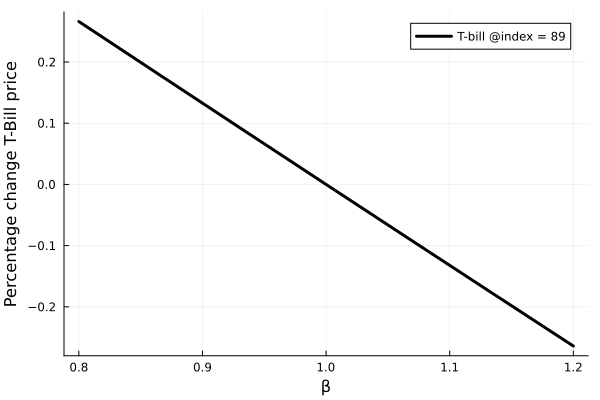

In [25]:
plot(theorem_1_simulation_array[:,1], theorem_1_simulation_array[:,2], lw=3, c=:black, xlabel="β", 
        ylabel="Percentage change T-Bill price", label="T-bill @index = $(random_bill_index)")